In [1]:
import os
import random
import argparse
import numpy as np
import tensorflow as tf
import voxelmorph_local as vxm
import pdb


# disable eager execution
tf.compat.v1.disable_eager_execution()


# parse the commandline
parser = argparse.ArgumentParser()

# data organization parameters
# norm_Abdominal_list
parser.add_argument('--img-list', default='LR.txt', help='line-seperated list of training files')
parser.add_argument('--img-prefix', help='optional input image file prefix')
parser.add_argument('--img-suffix', help='optional input image file suffix')
parser.add_argument('--atlas', help='optional atlas filename')
parser.add_argument('--model-dir', default='models',
                    help='model output directory (default: models)')
parser.add_argument('--multichannel', action='store_true',
                    help='specify that data has multiple channels')

# training parameters
parser.add_argument('--gpu', default='0', help='GPU ID numbers (default: 0)')
parser.add_argument('--batch-size', type=int, default=1, help='batch size (default: 1)')
parser.add_argument('--epochs', type=int, default=1500,
                    help='number of training epochs (default: 1500)')
parser.add_argument('--steps-per-epoch', type=int, default=100,
                    help='frequency of model saves (default: 100)')
parser.add_argument('--load-weights', help='optional weights file to initialize with')
parser.add_argument('--initial-epoch', type=int, default=0,
                    help='initial epoch number (default: 0)')
parser.add_argument('--lr', type=float, default=1e-4, help='learning rate (default: 1e-4)')

# network architecture parameters
parser.add_argument('--enc', type=int, nargs='+',
                    help='list of unet encoder filters (default: 16 32 32 32)')
parser.add_argument('--dec', type=int, nargs='+',
                    help='list of unet decorder filters (default: 32 32 32 32 32 16 16)')
parser.add_argument('--int-steps', type=int, default=7,
                    help='number of integration steps (default: 7)')
parser.add_argument('--int-downsize', type=int, default=2,
                    help='flow downsample factor for integration (default: 2)')
parser.add_argument('--use-probs', action='store_true', help='enable probabilities')
parser.add_argument('--bidir', action='store_true', help='enable bidirectional cost function')

# loss hyperparameters
parser.add_argument('--image-loss', default='mse',
                    help='image reconstruction loss - can be mse or ncc (default: mse)')
parser.add_argument('--lambda', type=float, dest='lambda_weight', default=0.01,
                    help='weight of gradient or KL loss (default: 0.01)')
parser.add_argument('--kl-lambda', type=float, default=10,
                    help='prior lambda regularization for KL loss (default: 10)')
parser.add_argument('--legacy-image-sigma', dest='image_sigma', type=float, default=1.0,
                    help='image noise parameter for miccai 2018 network (recommended value is 0.02 when --use-probs is enabled)')  # nopep8
args = parser.parse_args(args=[])

In [2]:
# load and prepare training data
train_files = vxm.py.utils.read_file_list(args.img_list, prefix=args.img_prefix,
                                          suffix=args.img_suffix)
assert len(train_files) > 0, 'Could not find any training data.'

# no need to append an extra feature axis if data is multichannel
add_feat_axis = not args.multichannel


if args.atlas:
    # scan-to-atlas generator
    atlas = vxm.py.utils.load_volfile(args.atlas, np_var='vol',
                                      add_batch_axis=True, add_feat_axis=add_feat_axis)
    generator = vxm.generators.scan_to_atlas(train_files, atlas,
                                             batch_size=args.batch_size,
                                             bidir=args.bidir,
                                             add_feat_axis=add_feat_axis)
else:
    # scan-to-scan generator
    generator = vxm.generators.scan_to_scan(
        train_files, batch_size=args.batch_size, bidir=args.bidir, add_feat_axis=add_feat_axis, pad_shape=(512, 512, 96))

# extract shape and number of features from sampled input
tmp = next(generator)
sample_shape = next(generator)[0][0].shape
inshape = sample_shape[1:-1]
nfeats = sample_shape[-1]

# prepare model folder
model_dir = args.model_dir
os.makedirs(model_dir, exist_ok=True)

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(args.gpu)
assert np.mod(args.batch_size, nb_devices) == 0, \
    'Batch size (%d) should be a multiple of the nr of gpus (%d)' % (args.batch_size, nb_devices)

# unet architecture
enc_nf = args.enc if args.enc else [16, 32, 32, 32]
dec_nf = args.dec if args.dec else [32, 32, 32, 32, 32, 16, 16]

# prepare model checkpoint save path
save_filename = os.path.join(model_dir, '{epoch:04d}.h5')

In [3]:
sample_shape

(1, 256, 256, 96, 1)

In [4]:
inshape

(256, 256, 96)

In [5]:
nfeats

1

(256, 256)
(256, 256)
(256, 256)
(256, 256)


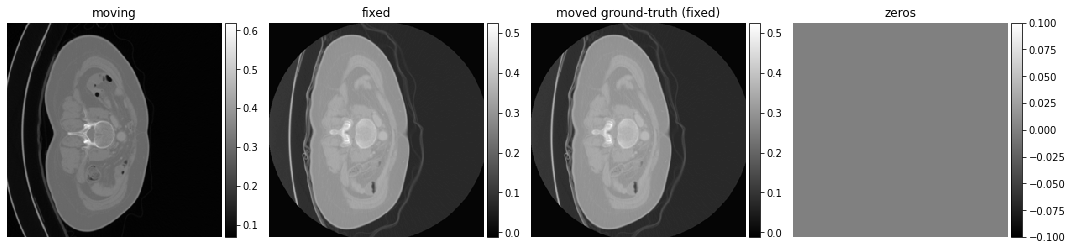

In [6]:
in_sample, out_sample = next(generator)
import neurite as ne
images = [img[0, :, :, 50, 0] for img in in_sample + out_sample] 
for img in images:
    print(img.shape)
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

(256, 256)
(256, 256)
(256, 256)
(256, 256)


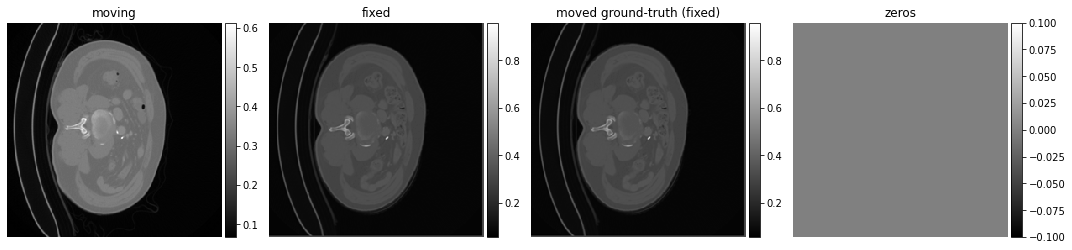

In [9]:
in_sample, out_sample = next(generator)
import neurite as ne
images = [img[0, :, :, 50, 0] for img in in_sample + out_sample] 
for img in images:
    print(img.shape)
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

(256, 256)
(256, 256)
(256, 256)
(256, 256)


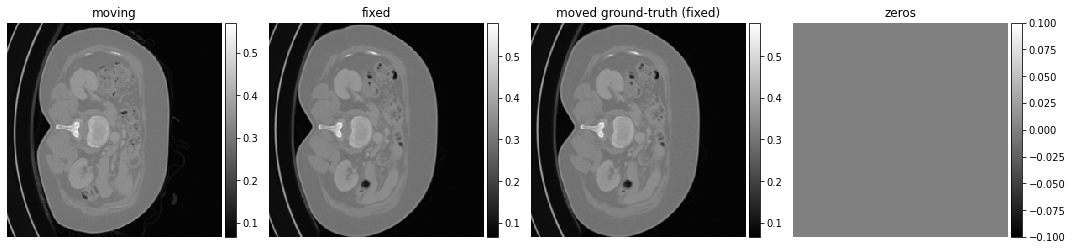

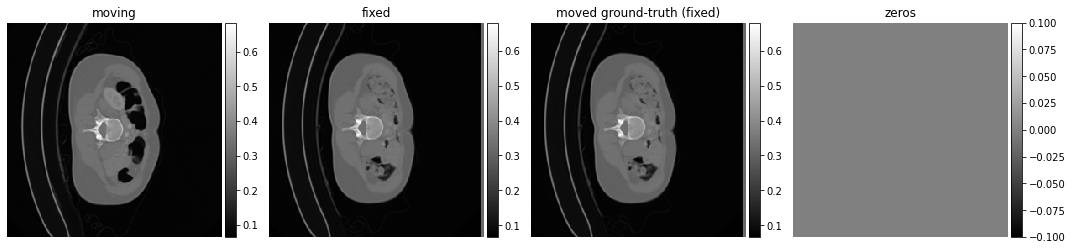

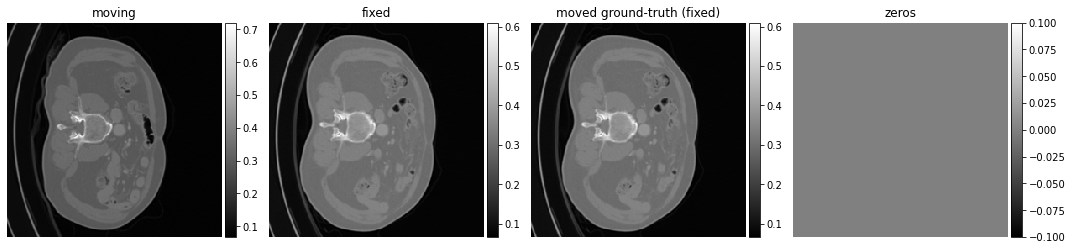

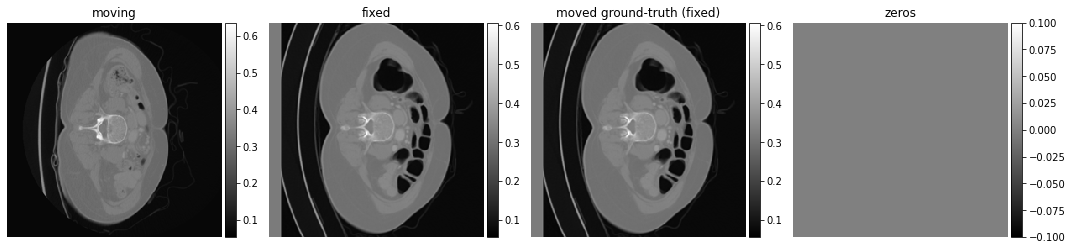

In [10]:
in_sample, out_sample = next(generator)
import neurite as ne
images = [img[0, :, :, 50, 0] for img in in_sample + out_sample] 
for img in images:
    print(img.shape)
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
in_sample, out_sample = next(generator)
import neurite as ne
images = [img[0, :, :, 50, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
in_sample, out_sample = next(generator)
import neurite as ne
images = [img[0, :, :, 50, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
in_sample, out_sample = next(generator)
import neurite as ne
images = [img[0, :, :, 50, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

[2]
../data_ct/s002/baseline/nifti/ct.nii.gz
[3]
../data_ct/s002/followup/nifti/ct.nii.gz
(512, 512)
(512, 512)
(512, 512)
(512, 512)


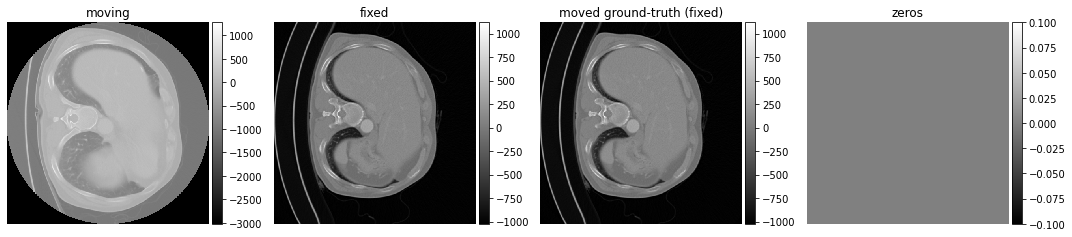

[4]
../data_ct/s003/baseline/nifti/ct.nii.gz
[5]
../data_ct/s003/followup/nifti/ct.nii.gz
(512, 512)
(512, 512)
(512, 512)
(512, 512)


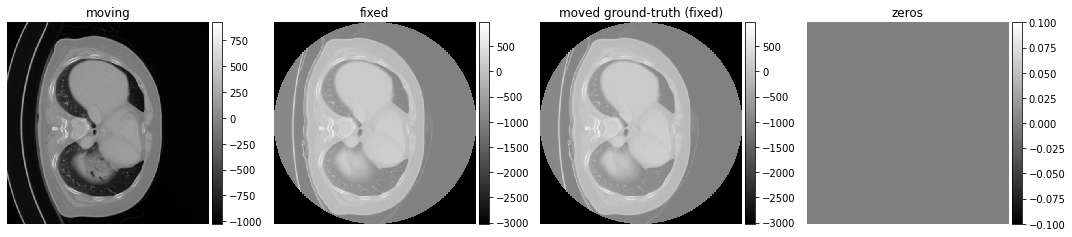

[6]
../data_ct/s004/baseline/nifti/ct.nii.gz
[7]
../data_ct/s004/followup/nifti/ct.nii.gz
(512, 512)
(512, 512)
(512, 512)
(512, 512)


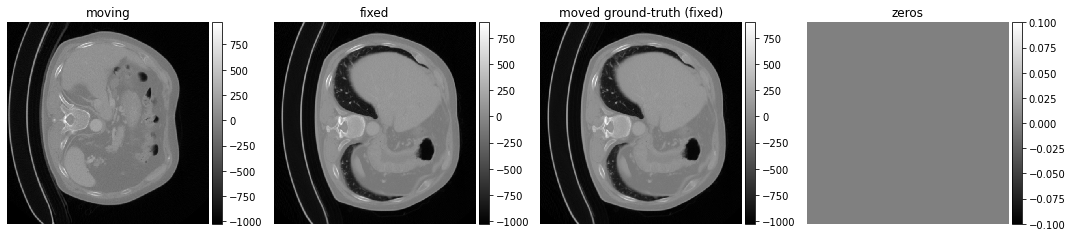

[8]
../data_ct/s005/baseline/nifti/ct.nii.gz
[9]
../data_ct/s005/followup/nifti/ct.nii.gz
(512, 512)
(512, 512)
(512, 512)
(512, 512)


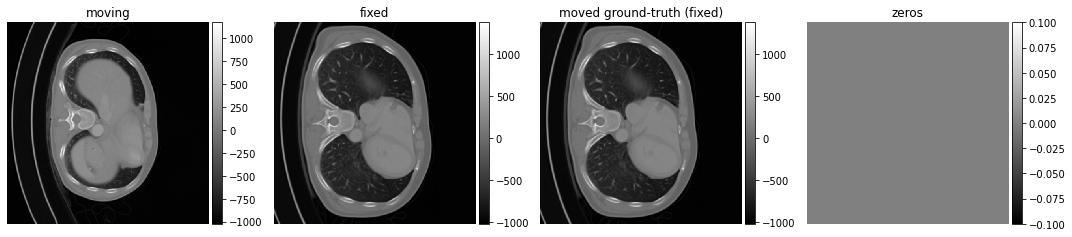

[10]
../data_ct/s006/baseline/nifti/ct.nii.gz
[11]
../data_ct/s006/followup/nifti/ct.nii.gz
(512, 512)
(512, 512)
(512, 512)
(512, 512)


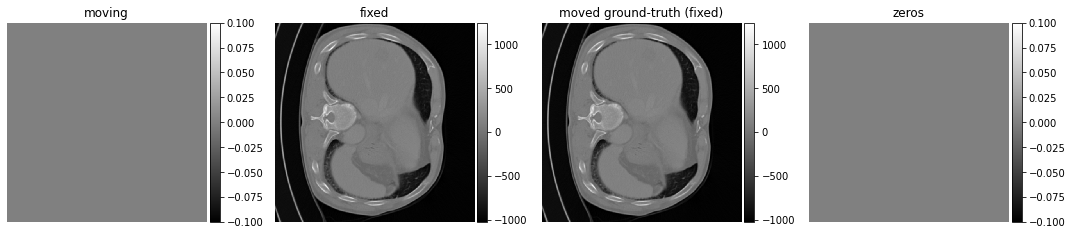

In [9]:
for i in range(5):
    in_sample, out_sample = next(generator)
    import neurite as ne
    images = [img[0, :, :, 100, 0] for img in in_sample + out_sample] 
    for img in images:
        print(img.shape)
    titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
    ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [21]:
f = open("Abdominal_list.txt", 'w')
for i in range(100):
    if i != 5:
        f.write("../data_ct/s%03d/baseline/nifti/ct.nii.gz\n" % (i + 1))
        f.write("../data_ct/s%03d/followup/nifti/ct.nii.gz\n" % (i + 1))
f.close()

In [6]:
indices = np.zeros(2, dtype=int)
indices

array([0, 0])

In [9]:
indices += 1
indices

array([1, 1])

In [8]:
indices *= 0
indices

array([0, 0])

In [6]:
tmp = next(generator)

[4]
[5]


In [27]:
tmp[0][0].type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [17]:
array=np.zeros((512,512,95))
shape=(512,512,96)

In [18]:
padded = np.zeros(shape, dtype=array.dtype)
padded.shape

(512, 512, 96)

In [19]:
offsets = [(p - v) / 2 for p, v in zip(shape, array.shape)]
offsets

[0.0, 0.0, 0.5]

In [20]:
p = int(offsets[2])
if offsets[2] >= 0:
    padded[:, :, p:p + array.shape[2]] = array
    print(padded.shape)
    print(array.shape)
else:
    padded = array[:, :, -p:-p + padded.shape[2]]
    print(array.shape)
    print(padded.shape)

(512, 512, 96)
(512, 512, 95)


In [8]:
# slices = tuple([slice(offset, l + offset) for offset, l in zip(offsets, array.shape)])
p = offsets[2]
if offsets[2] < 0:
    p = 0
slices_padded = tuple([slice(0, 256), slice(0, 256), slice(p, p + array.shape[2])])
if offsets[0] < 0:
    s = -offsets[0]
else:
    s = 0
if offsets[2] < 0:
    p = -offsets[2]
else:
    p = 0
slices_array = tuple([slice(s, s + 256), slice(s, s + 256), slice(p, p + array.shape[2])])

In [17]:
padded

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [7]:
# build the model
model = vxm.networks.VxmDense(
    inshape=inshape,
    nb_unet_features=[enc_nf, dec_nf],
    bidir=args.bidir,
    use_probs=args.use_probs,
    int_steps=args.int_steps,
    int_resolution=args.int_downsize,
    src_feats=nfeats,
    trg_feats=nfeats
)

# load initial weights (if provided)
if args.load_weights:
    model.load_weights(args.load_weights)

# prepare image loss
if args.image_loss == 'ncc':
    image_loss_func = vxm.losses.NCC().loss
elif args.image_loss == 'mse':
    image_loss_func = vxm.losses.MSE(args.image_sigma).loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

# need two image loss functions if bidirectional
if args.bidir:
    losses = [image_loss_func, image_loss_func]
    weights = [0.5, 0.5]
else:
    losses = [image_loss_func]
    weights = [1]

# prepare deformation loss
if args.use_probs:
    flow_shape = model.outputs[-1].shape[1:-1]
    losses += [vxm.losses.KL(args.kl_lambda, flow_shape).loss]
else:
    losses += [vxm.losses.Grad('l2', loss_mult=args.int_downsize).loss]

weights += [args.lambda_weight]

# multi-gpu support
if nb_devices > 1:
    save_callback = vxm.networks.ModelCheckpointParallel(save_filename)
    model = tf.keras.utils.multi_gpu_model(model, gpus=nb_devices)
else:
    save_callback = tf.keras.callbacks.ModelCheckpoint(save_filename, period=20)

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=args.lr), loss=losses, loss_weights=weights)

# save starting weights
model.save(save_filename.format(epoch=args.initial_epoch))

model.fit_generator(generator,
                    initial_epoch=args.initial_epoch,
                    epochs=args.epochs,
                    steps_per_epoch=args.steps_per_epoch,
                    callbacks=[save_callback],
                    verbose=1
                    )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/1500
 35/100 [=========>....................] - ETA: 2:30 - batch: 17.0000 - size: 1.0000 - loss: 0.0074 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_resize_loss: 1.7888e-04

KeyboardInterrupt: 